# SIF Explainer Tutorial
#### This tutorial illustrates the use of SIF algorithm, a comprehensive single-valued metric, to measure outlier impacts on future predictions. It provides a quantitative measure regarding the outlier impacts,  which can be used in a variety of scenarios, such as the evaluation of outlier detection methods, the creation of more harmful outliers, etc. This is a demonstration for AAAI-2021 paper [paper:Outlier Impact Characterization for Time Series Data](https://ojs.aaai.org/index.php/AAAI/article/view/17379).
#### SIF algorithm mainly tackles the challenge of outlier interpretation in time series data via [contamination processes](https://www.jstor.org/stable/pdf/3035535.pdf). It assumes that the observed input time series is obtained from separate processes for both the core input and the recurring outliers, i.e., the core process and the contaminating process. At each time stamp, with a certain (small) probability, the observed value of the contaminated process comes from the contaminating process, which corresponds to the outliers. The SIF algorithm focuses on the generic patchy outliers where the outlying patterns can be present over consecutive time stamps, and aims to study the impact of the contaminating process on both parameter estimation and future value prediction.
#### The tutorial is organized as folows:
#### 1. [Train a Model Inherited from SIFExplainer](https://github.com/Leo02016/AIX360/blob/dc0efab88b90f225427347b080897a3e19792403/examples/sif/SIF.ipynb#L12)
#### 2. [Initialize the Required Parameters and Synthesize the Dataset](https://github.com/Leo02016/AIX360/blob/dc0efab88b90f225427347b080897a3e19792403/examples/sif/SIF.ipynb#L61)
#### 3. [Interpret the Model by SIF Value](https://github.com/Leo02016/AIX360/blob/dc0efab88b90f225427347b080897a3e19792403/examples/sif/SIF.ipynb#L139)

## 1. Train a Model Inherited from SIFExplainer
#### First, we define a function that trains a AR2 model inherited from SIFExplainer and this model (AR2) is what we are going to interpret. Notice that the AR2 model below can be changed to AllLSTM or AllRNN model defined in SIF_NN.py file. AllRNN, AllLSTM, AllAR are also inherited from SIFExplainer Model defined in SIF.py file.

In [1]:
import numpy as np
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from aix360.datasets.SIF_dataset import DataSetTS
from aix360.algorithms.sif.SIF_NN import AllRNN, AllLSTM, AllAR
from aix360.algorithms.sif.SIF_utils import get_contaminate_series
import os
import pickle

# arma2 model
def get_model_train_ar2(data_sets, series, timesteps, w=None, gammas=None, num_train_steps=20000,
                        model_dir=None):
    initial_learning_rate = 0.01
    decay_epochs = [10000, 20000]
    batch_size = 20
    n_sample = series.shape[1] if len(series.shape) > 1 else 1

    # model can be changed to AllLSTM or AllRNN model defined in SIF_NN.py
    model = AllAR(
        time_steps=timesteps,
        x_dim=n_sample,
        y_dim=n_sample,
        share_param=True,
        batch_size=batch_size,
        time_series=series,
        data_sets=data_sets,
        initial_learning_rate=initial_learning_rate,
        damping=1e-3,
        decay_epochs=decay_epochs,
        mini_batch=False,
        train_dir='arma_output',
        log_dir='logs',
        model_name='ar_test',
        calc_hessian=False,
        w=w,
        gammas=gammas,
    )
    if model_dir is not None:
        print('Loading pre-trained model......')
        model.restore(model_dir)
    else:
        model.train(num_steps=num_train_steps, iter_to_switch_to_batch=10, iter_to_switch_to_sgd=10)
    return model

Using TensorFlow backend.


## 2. Initialize the Required Parameters and Synthesize the Dataset
#### In the second step, we initialize the parameters for SIFExplainer. 
#### By default, we use the fast mode to accelerate the computation. In the fast mode, we load the pre-trained AR2 model and dataset to skip training stage. If the user plans to retrain the AR2 model, please set the parameter [fast_mode](https://github.com/Leo02016/AIX360/blob/dc0efab88b90f225427347b080897a3e19792403/examples/sif/SIF.ipynb#L65) to be False. Then, the algorithm will generate a new synthetic dataset and train AR2 model from scratch.


In [2]:
fast_mode = True

# parameters
timesteps = 2
np.random.seed(1)
n_sample = 1000
n_time_stamp = 100
gammas = np.arange(0.0, 0.09, 0.01)

#### Please ensure that data.pkl and model are downloaded in the following directories.

In [3]:
data_dir = '../../aix360/data/sif_data/data.pkl'
model_dir = '../../aix360/models/sif/ar2'


#### Skip generating the synthetic dataset and training the model if using fast-mode. In the fast mode, we directly load the saved dataset and pre-trained model

In [4]:
if fast_mode:
    assert os.path.exists(data_dir), "Could not find the data.pkl in {}".format(data_dir)
    # load time series from data.pkl file
    series = pickle.load(open(data_dir, "rb"))
    data_sets = DataSetTS(np.arange(len(series)), np.array(['Y']), None, None, None,
                          lag=timesteps).datasets_gen_rnn()
    # initialize and train the model which takes the clean time sequence as input and makes prediction
    model = get_model_train_ar2(data_sets, series, timesteps, gammas=gammas, model_dir=model_dir)
else:
    # ar and ma are two parameters controlling the synthetic time sequence data
    ar = np.r_[1, -np.array([0.7, -0.3])]
    ma = np.r_[1, -np.array([0.1])]

    # generate the core process or clean time sequence data
    series = [smt.arma_generate_sample(ar, ma, n_time_stamp) for i in range(n_sample)]
    series = np.vstack(series)
    pickle.dump(series, open(data_dir, "wb"))
    data_sets = DataSetTS(np.arange(len(series)), np.array(['Y']), None, None, None,
                          lag=timesteps).datasets_gen_rnn()
    # initialize and train the model which takes the clean time sequence as input and makes prediction
    model = get_model_train_ar2(data_sets, series, timesteps, gammas=gammas, model_dir=None)
    model.save(model_dir)






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where







Total number of parameters: 2
Loading pre-trained model......
INFO:tensorflow:Restoring parameters from ../../aix360/models/sif/ar2


#### y_contaminate is considered as the contaminating process in the experiment

In [5]:
y_contaminate = np.random.randn(n_sample)
model.update_configure(y_contaminate, gammas)

#### Insert the contaminated data into the clean time sequence data

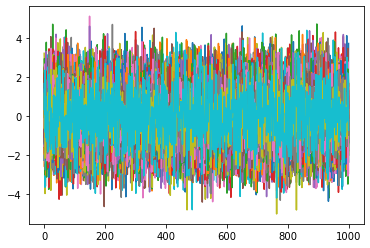

In [7]:
contaminated_series = get_contaminate_series(series, y_contaminate, data_sets.train.labels)
# plot contaminated series
# plt.plot(contaminated_series)
# plt.show()
# plt.close()


## 3. Interpret the Model by SIF Value
#### In the last step, we compute SIF value. Notice that the model is inherited from SIFExplainer and the user could simply call model.explain_instance() function to get the SIF value.

In [8]:
# compute SIF value
sif = model.explain_instance(y_contaminate, timesteps, 1, None, 30, verbose=False)
print('SIF = {}'.format(sif))


Regression R-squared: 0.179848
162.92198777198792 s to compute if_v
0.03913569450378418 s to compute patchy pred gamma
0.0718080997467041 s to compute psi_y
SIF = -119.54141353277345
